### Sentiment Analysis of Customer Reviews

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV
import nltk
import warnings
warnings.filterwarnings("ignore")

In [2]:
##reading dataset
df = pd.read_csv(r"Reviews.csv")

print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Data Preparation

Here we have Helpfulness Numerator and Denominator, we add a column for upvote metrics, ie the helpfulness.

In [4]:
df["Helpfullness"] = np.where(df["HelpfulnessDenominator"] > 0, df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"], -1)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfullness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0


In [6]:
df["Helpfullness"].unique()

array([ 1.        , -1.        ,  0.8       ,  0.        ,  0.5       ,
        0.66666667,  0.25      ,  0.89473684,  0.83333333,  0.75      ,
        0.33333333,  0.3       ,  0.11111111,  0.42857143,  0.875     ,
        0.85714286,  0.2       ,  0.26315789,  0.6       ,  0.71428571,
        0.53846154,  0.57142857,  0.91489362,  0.86666667,  0.82352941,
        0.78571429,  0.74074074,  0.4       ,  0.375     ,  0.28571429,
        0.14285714,  0.77777778,  0.125     ,  0.9       ,  0.94117647,
        0.92307692,  0.7       ,  0.45454545,  0.88888889,  0.83870968,
        0.9047619 ,  0.92857143,  0.90909091,  0.91666667,  0.84615385,
        0.10526316,  0.98214286,  0.97826087,  0.7518797 ,  0.3125    ,
        0.1       ,  0.18518519,  0.88      ,  0.69230769,  0.625     ,
        0.54545455,  0.41666667,  0.45833333,  0.22222222,  0.81818182,
        0.8125    ,  0.16666667,  0.93103448,  0.88235294,  0.23529412,
        0.63636364,  0.81481481,  0.95652174,  0.64285714,  0.58

As we can see, there are so many unique value ranging from 0 to 1. So I am going to use decile analysis by adding bins. Assigning different labels to helpfullness according to its value.

In [7]:
df["Upvote"] = pd.cut(df["Helpfullness"] , bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ["Not Helpful", "Poor", "Bad", "Good", "Excellent", "Amazing"])

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfullness,Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,Amazing
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,Amazing
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,Amazing
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


#### GroupBy

In [9]:
df.groupby(["Score", "Upvote"]).agg("count")

Id  ProductId  UserId  ProfileName  \
Score Upvote                                                
1     Not Helpful    8060       8060    8060         8060   
      Poor           2338       2338    2338         2338   
      Bad            4649       4649    4649         4649   
      Good           6586       6586    6586         6586   
      Excellent      5838       5838    5838         5836   
      Amazing       12531      12531   12531        12531   
2     Not Helpful    4234       4234    4234         4234   
      Poor            762        762     762          762   
      Bad            1618       1618    1618         1618   
      Good           3051       3051    3051         3051   
      Excellent      2486       2486    2486         2486   
      Amazing        7014       7014    7014         7014   
3     Not Helpful    5062       5062    5062         5062   
      Poor            474        474     474          474   
      Bad            1506       1506    1506         1506   
      Good           3384       3384    3384         3384   
      Excellent      2754       2754    2754         2754   
      Amazing       11037      11037   11037        11037   
4     Not Helpful    4780       4780    4780         4780   
      Poor            116        116     116          116   
      Bad             909        909     909          909   
      Good           3185       3185    3185         3185   
      Excellent      2941       2941    2941         2941   
      Amazing       26707      26707   26707        26707   
5     Not Helpful   11638      11638   11638        11638   
      Poor            432        432     432          432   
      Bad            2275       2275    2275         2275   
      Good          10312      10312   10312        10312   
      Excellent     11060      11060   11060        11060   
      Amazing      140661     140661  140661       140659   

                   HelpfulnessNumerator  HelpfulnessDenominator    Time  \
Score Upvote                                                              
1     Not Helpful                  8060                    8060    8060   
      Poor                         2338                    2338    2338   
      Bad                          4649                    4649    4649   
      Good                         6586                    6586    6586   
      Excellent                    5838                    5838    5838   
      Amazing                     12531                   12531   12531   
2     Not Helpful                  4234                    4234    4234   
      Poor                          762                     762     762   
      Bad                          1618                    1618    1618   
      Good                         3051                    3051    3051   
      Excellent                    2486                    2486    2486   
      Amazing                      7014                    7014    7014   
3     Not Helpful                  5062                    5062    5062   
      Poor                          474                     474     474   
      Bad                          1506                    1506    1506   
      Good                         3384                    3384    3384   
      Excellent                    2754                    2754    2754   
      Amazing                     11037                   11037   11037   
4     Not Helpful                  4780                    4780    4780   
      Poor                          116                     116     116   
      Bad                           909                     909     909   
      Good                         3185                    3185    3185   
      Excellent                    2941                    2941    2941   
      Amazing                     26707                   26707   26707   
5     Not Helpful                 11638                   11638   11638   
      Poor                          432      

Considering only Id Column, as I want have count no. of user associated with Upvotes for different categories.

In [10]:
df.groupby(["Score", "Upvote"]).agg({"Id":'count'})

Id
Score Upvote             
1     Not Helpful    8060
      Poor           2338
      Bad            4649
      Good           6586
      Excellent      5838
      Amazing       12531
2     Not Helpful    4234
      Poor            762
      Bad            1618
      Good           3051
      Excellent      2486
      Amazing        7014
3     Not Helpful    5062
      Poor            474
      Bad            1506
      Good           3384
      Excellent      2754
      Amazing       11037
4     Not Helpful    4780
      Poor            116
      Bad             909
      Good           3185
      Excellent      2941
      Amazing       26707
5     Not Helpful   11638
      Poor            432
      Bad            2275
      Good          10312
      Excellent     11060
      Amazing      140661

Storing this Information in A Dataframe

In [11]:
data = df.groupby(["Score", "Upvote"]).agg({"Id":'count'}).reset_index()

In [12]:
data.head()

,Score,Upvote,Id
0,1,Not Helpful,8060
1,1,Poor,2338
2,1,Bad,4649
3,1,Good,6586
4,1,Excellent,5838


### Pivot Table

In [13]:
data.pivot(index="Upvote", columns='Score')

Id                            
Score            1     2      3      4       5
Upvote                                        
Not Helpful   8060  4234   5062   4780   11638
Poor          2338   762    474    116     432
Bad           4649  1618   1506    909    2275
Good          6586  3051   3384   3185   10312
Excellent     5838  2486   2754   2941   11060
Amazing      12531  7014  11037  26707  140661

### Visualization

In [14]:
pivot = data.pivot(index="Upvote", columns='Score')

#### Heatmap

Text(0.5, 1.0, 'Reviews with respect to Scores')

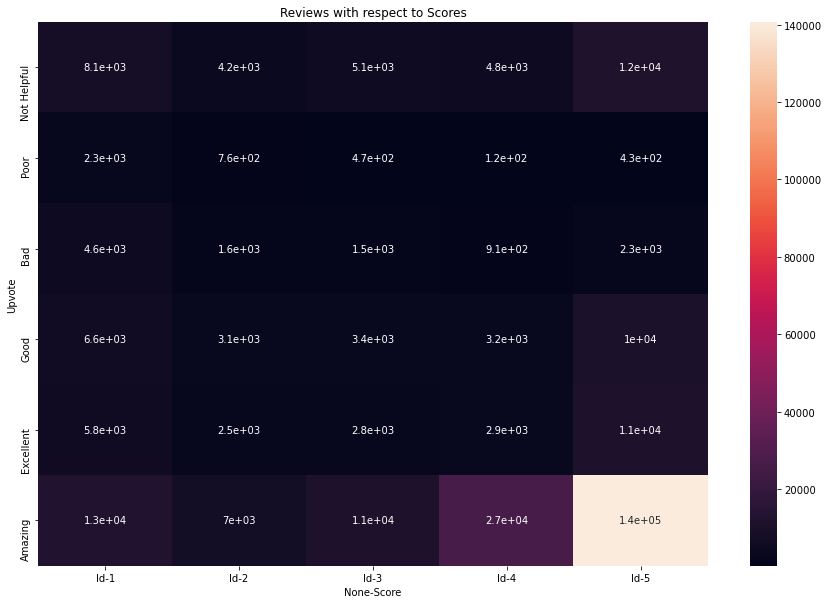

In [15]:
plt.figure(figsize = (15,10))
sns.heatmap(data.pivot(index="Upvote",columns='Score'),annot=True)
plt.title("Reviews with respect to Scores")

**To Note**
- Reviews are skewed towards positive
- More than half of the reviews are with 0 ie Not Helpful votes
- Many people agree with score 5 reviews

In [16]:
df.shape

(568454, 12)

In [17]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfullness,Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,Amazing
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,Amazing
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,Amazing
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


### Steps in NLP with an Example

Suppose, we have a data that we store in:

Sentence 1 =  It is going to rain Today.
Sentence 2 =  today I am  not going outside.

1. **Lowering the sentences.**
    When I'll give this data to the machine learning model, it will consider, "Today" and "today" as a unique characters, where as we know, they are of the same nature. Hence performing this step, is important to avoid redundancy.

2. **Tokenization.**
    User1:
    It
    is
    going
    to
    rain
    today
    
    User2:
    today
    I
    am
    not 
    going
    outside

3. **Short the data.**
    Let's say I'm going to create a Histogram. To count the frequencies/occurences.
    
    it -    1
    is -    1
    going - 2
    to -    1
    rain -  1
    today - 2
    i -     1
    am -    1
    not -   1
    out -   1 

4. **Filteration.** Remove the less frequent words. In our eg: we dont have less frequent data, but in large data this scenario comes in action.

5. **Create a matrix.**
    Bow Matrix or Document Matrix is passed to the ML Model, ie in the form of vectors so the model understand's the data / vector.
    
    - Token: it is going to rain today i am not out
    - Sen1    1  1  1     1  1    1     0 0  0   0
    - Sen2    0   0  1    0   0   1    1  1  1   1
    
    
    So this is how the tokens and matrix is made.

**Bow Matrix**
    It will assign importance to each token/word. In the form of 0 and 1. Suppose we have a data: 
    
   - Sen: He is a very Intelligent Boy.
   - Bow: 0  0  0  0     1          1
   
As we can see, Intelligent is the most important word here, but bow assigned 1 to both Intelligent and Boy as well. This can be a drawback when it comes to Bow.
To get rid of this we have, **TF-IDF**

   - Sen   : He is a very Intelligent Boy.
   - TF-IDF: 0  0  0  0      0.8      0.4

So, TF-IDF will assign values like these, hence we know, word Intelligent is more important.
    

### Bag of Words

In [18]:
df["Score"].unique()

array([5, 1, 4, 2, 3], dtype=int64)

So as we can see, there are scores from 1-5, 3 being the nuetral score, which makes no sense to make prediction for score 3. Hence I am going to eliminate the data from scores 1,2,4,5

In [19]:
data = df[df["Score"] != 3]

In [20]:
data["Score"].unique()

array([5, 1, 4, 2], dtype=int64)

In [21]:
x = data["Text"]

Wherever score is < 3, mapping it with 0, ad > 3, mapping it with 1

In [22]:
y_dict = {1:0, 2:0, 4:1, 5:1}
y = data["Score"].map(y_dict)

#### Convert text into vectors using NLP

Stop Word are words like, he, she, it; which makes no sense in my data. 

In [23]:
c = CountVectorizer(stop_words = "english")

In [24]:
X= c.fit_transform(x)

In [25]:
print("Features: {}".format(X.shape[1]))

Features: 114969


In [26]:
X.shape

(525814, 114969)

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

By default, 75% of data will be taken for training data.

In [28]:
print("Train Records: {}".format(xtrain.shape[0]))

Train Records: 394360


In [29]:
lr=LogisticRegression()

In [30]:
ml = lr.fit(xtrain, ytrain)
acc = ml.score(xtest, ytest)
print ('Model Accuracy: {}'.format(acc))

Model Accuracy: 0.9360764982427313


#### Fetch Top 20 Positive & Top 20 Negative words Of the Model we built.

In [31]:
w = c.get_feature_names()
w

['00',
 '000',
 '0000',
 '000001',
 '00001',
 '000013',
 '0000soo',
 '0001',
 '000111052',
 '0002251337',
 '0003',
 '0004',
 '000iu',
 '000kwh',
 '000mg',
 '000mi',
 '000s',
 '000su',
 '000usd',
 '000v',
 '001',
 '00100',
 '00127',
 '00128',
 '00129',
 '00130',
 '00131',
 '00132',
 '00134',
 '00136',
 '00139',
 '001bru',
 '002',
 '0020100604',
 '00202',
 '00227',
 '0023',
 '003',
 '004',
 '00493',
 '005',
 '00533',
 '0060187654',
 '0060721855',
 '0060928115',
 '0060959584',
 '0061658197',
 '006176793x',
 '0067575986',
 '0069615',
 '007',
 '00703',
 '00704',
 '0071468633',
 '0071477845',
 '0071486011',
 '0071499849',
 '008',
 '0099',
 '00a',
 '00am',
 '00b',
 '00gr',
 '00lb',
 '00m',
 '00pm',
 '00s',
 '00something',
 '00z',
 '01',
 '010',
 '0100',
 '01014',
 '01069',
 '011',
 '012',
 '013',
 '01317',
 '01318',
 '014',
 '0140444254',
 '0140446680',
 '0143114964',
 '014mg',
 '015',
 '017',
 '0174',
 '018',
 '0188',
 '019',
 '01915',
 '0199232768',
 '0199535892',
 '0199536066',
 '02',
 '02

Extract coeff of my model.

In [32]:
coef = ml.coef_.tolist()[0]
coef

[-0.3246675186424674,
 0.2966473112852244,
 0.1849043220460309,
 -0.007259386691154793,
 -0.010843659080824502,
 -0.012729179077048944,
 0.00038419088035137325,
 0.0004803106929765338,
 0.0004803106929765338,
 0.0004150213982404865,
 0.0,
 -0.014977503080399072,
 0.006960839719923905,
 0.01460337815158646,
 -0.420422429063189,
 0.0041373858587197415,
 0.002471787610963507,
 0.0029534049212121263,
 0.0006182006663204385,
 6.960414226452985e-05,
 0.11537825866848202,
 0.013339021634538307,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.03252384334163193,
 0.0,
 0.06037170943136685,
 0.00014666819806987864,
 0.0,
 0.0,
 0.00015440222154313268,
 0.002534174765141743,
 0.047334026584117186,
 2.6080920011491487e-05,
 -0.12497162922813011,
 0.011310550858178255,
 4.27134646954401e-05,
 0.005218670726819518,
 -0.059741502865791815,
 0.00012628300476538422,
 0.0,
 

Creating a df for the words and it's Coefficients

In [33]:
coeff_data = pd.DataFrame({"Word" : w, "Coefficient" : coef})
coeff_data

,Word,Coefficient
0,00,-0.324668
1,000,0.296647
2,0000,0.184904
3,000001,-0.007259
4,00001,-0.010844
...,...,...
114964,çaykur,0.000908
114965,çelem,-0.127143
114966,être,0.019579
114967,île,0.010097


Sorting the dataframe on basis of the Coeff

In [34]:
coeff_data = coeff_data.sort_values(["Coefficient", "Word"],ascending=False)
coeff_data

,Word,Coefficient
80600,pleasantly,4.264287
39072,downside,3.144090
5865,addicting,2.982962
94667,skeptical,2.945150
55029,hooked,2.668465
...,...,...
113164,worst,-3.304604
37560,disappointing,-3.335826
34989,deceptive,-3.510355
106852,unacceptable,-3.585344


In [35]:
print("Top 20 Positive Words")
print(coeff_data.head(20).to_string(index=False))

Top 20 Positive Words
      Word  Coefficient
pleasantly     4.264287
  downside     3.144090
 addicting     2.982962
 skeptical     2.945150
    hooked     2.668465
   worries     2.473482
  drawback     2.421916
    resist     2.392208
   easiest     2.248956
  tastiest     2.173178
      whim     2.169212
   trainer     2.168589
 delighted     2.165653
  terrific     2.137959
    solved     2.133444
economical     2.118910
    delish     2.093919
 excellent     2.075916
   welcome     2.066068
  heavenly     2.056448


In [36]:
print("Top 20 Negative Words")        
print(coeff_data.tail(20).to_string(index=False))

Top 20 Negative Words
          Word  Coefficient
         blech    -2.345496
       sounded    -2.472373
        bummer    -2.486255
        lacked    -2.492948
       vomited    -2.505230
    flavorless    -2.578611
    overpowers    -2.674278
disappointment    -2.684924
         lousy    -2.692814
      mediocre    -2.704158
    returnable    -2.785599
        ripoff    -2.959315
     cancelled    -2.989247
   embarrassed    -3.055532
   disapointed    -3.135172
         worst    -3.304604
 disappointing    -3.335826
     deceptive    -3.510355
  unacceptable    -3.585344
   undrinkable    -3.926101


### Automate 
- Apply Bag Of Words on the data
- Check Model Accuracy
- Fetch Top 20 Positive and Negative words

#### Lets create a function so that I can apply mutliple NLP Techniques + Multiple Ml algos in such a way that I will acheive my best accuracy

In [37]:
def text_fit(x, y, nlp_model,ml_model,coef_show=1):
    
    X = nlp_model.fit_transform(x)
    print("Features: {}".format(X.shape[1]))
    xtrain, xtest, ytrain, ytest = train_test_split(X, y)
    print(" Train Records: {}".format(xtrain.shape[0]))
    print(" Test Records: {}".format(xtest.shape[0]))
    ml =ml_model.fit(xtrain, ytrain)
    acc = ml.score(xtest, ytest)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = nlp_model.get_feature_names()
        coef = ml.coef_.tolist()[0]
        coeff_data = pd.DataFrame({"Word" : w, "Coefficient" : coef})
        coeff_data = coeff_data.sort_values(["Coefficient", "Word"], ascending=[0, 1])
        print('\n')
        print("----------------------Top 20 Positive Words-----------------------")
        print(coeff_data.head(20).to_string(index=False))
        print('\n')
        print("----------------------Top 20 Negative Words-----------------------")
        print(coeff_data.tail(20).to_string(index=False))

In [38]:
text_fit(x, y, c, LogisticRegression())

Features: 114969
 Train Records: 394360
 Test Records: 131454
Model Accuracy: 0.9358406743043194


----------------------Top 20 Positive Words-----------------------
      Word  Coefficient
pleasantly     3.841048
  downside     3.213842
 addicting     2.885188
 skeptical     2.768574
   worries     2.562147
    hooked     2.516403
  drawback     2.507852
    resist     2.443842
  terrific     2.345138
       met     2.339593
     penny     2.277091
  relaxing     2.095831
    delish     2.080064
      fits     2.058719
  hesitant     2.052849
economical     2.042754
    solved     2.039820
   trainer     2.022318
    intend     2.006245
 excellent     2.002555


----------------------Top 20 Negative Words-----------------------
          Word  Coefficient
         ruins    -2.411255
       defeats    -2.433360
           ick    -2.511069
       glowing    -2.542840
   embarrassed    -2.546563
       vomited    -2.564809
disappointment    -2.689030
     cancelled    -2.693627
   disapo

Now that, we have created a Fit function, let's make a predict function.

#### Lets define a predict function

In [40]:
from sklearn.metrics import confusion_matrix,accuracy_score
def predict(x, y, nlp_model, ml_model):
    
    X = nlp_model.fit_transform(x)
    print(" Features: {}".format(X.shape[1]))
    xtrain, xtest, ytrain, ytest = train_test_split(X, y)
    print(" Train Records: {}".format(xtrain.shape[0]))
    print(" Test Records: {}".format(xtest.shape[0]))
    ml = ml_model.fit(xtrain, ytrain)
    ypred = ml.predict(xtest)
    print("----------------------Confusion Matrix-----------------------")
    print('\n')
    cm=confusion_matrix(ypred,ytest)
    print(cm)
    print("----------------------Accuracy----------------------")
    acc=accuracy_score(ypred,ytest)
    print(acc)

In [41]:
predict(x, y, c, lr)

 Features: 114969
 Train Records: 394360
 Test Records: 131454
----------------------Confusion Matrix-----------------------


[[ 15040   2669]
 [  5480 108265]]
----------------------Accuracy----------------------
0.9380087330929451


### TF-IDF
**Term Frequency - Inverse Document Freq**

Multiplication of TF matrix into IDF matrix.

#### Accuracy is around 93.6% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

In [44]:
### calling function for dummy classifier 
text_fit(x, y, c, DummyClassifier(),0)

Features: 114969
 Train Records: 394360
 Test Records: 131454
Model Accuracy: 0.8440899478144446


### Logistic Regression on TF-IDF

#### Fit()

In [52]:
tfidf = TfidfVectorizer(stop_words = "english")
text_fit(x, y, tfidf, lr,1)

Features: 114969
 Train Records: 394360
 Test Records: 131454
Model Accuracy: 0.9347908774171954


----------------------Top 20 Positive Words-----------------------
      Word  Coefficient
     great    13.973023
 delicious    12.307802
      best    11.536201
   perfect    10.414438
 excellent     9.793142
     loves     9.494920
    highly     9.091449
      love     8.849861
 wonderful     8.117894
   amazing     7.840695
    hooked     7.651414
   awesome     7.573779
      good     7.501443
pleasantly     7.376094
  favorite     7.155922
      nice     7.118016
   pleased     6.753705
     yummy     6.661235
 fantastic     6.531236
    smooth     6.431900


----------------------Top 20 Negative Words-----------------------
          Word  Coefficient
         waste    -5.646160
          yuck    -5.797391
  unacceptable    -5.815334
         worse    -6.081576
         stale    -6.168507
   undrinkable    -6.185475
     tasteless    -6.288267
    disgusting    -6.390911
         

#### Predict()

In [51]:
predict(x, y, tfidf, lr)

 Features: 114969
 Train Records: 394360
 Test Records: 131454
----------------------Confusion Matrix-----------------------


[[ 14263   2274]
 [  6309 108608]]
----------------------Accuracy----------------------
0.9347071979551782


#### Upvote Prediction

`We will be focusing on score 5 reviews, and get rid of comments with neutral votes`

In [53]:
data = df[df["Score"] == 5]

In [54]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfullness', 'Upvote'],
      dtype='object')

In [55]:
data["Upvote"].unique()

['Amazing', NaN, 'Excellent', 'Not Helpful', 'Good', 'Bad', 'Poor']
Categories (6, object): ['Not Helpful' < 'Poor' < 'Bad' < 'Good' < 'Excellent' < 'Amazing']

In [59]:
f_data = data[data["Upvote"].isin(["Poor", "Bad", "Excellent", "Amazing"])]
f_data.shape

(154428, 12)

In [60]:
f_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfullness,Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,Amazing
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,Amazing
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,Amazing
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,Amazing
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,Excellent


In [61]:
x = f_data["Text"]

In [62]:
f_data["Upvote"].unique()

['Amazing', 'Excellent', 'Bad', 'Poor']
Categories (4, object): ['Poor' < 'Bad' < 'Excellent' < 'Amazing']

In [63]:
y_dict = {'Amazing':1, 'Excellent':1, 'Bad':0, 'Poor':0}
y = f_data["Upvote"].map(y_dict)

In [64]:
y.value_counts()

1.0    151721
0.0      2707
Name: Upvote, dtype: int64

#### The target class 'y' is highly skewed , we will observe positive upvotes are too much higher than negative ones.
    Let's resample the data to get balanced data

#### Balancing the Imbalanced Data

In [65]:
tf=TfidfVectorizer()

In [66]:
X=tf.fit_transform(x)

In [67]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,train_size=0.7)

In [68]:
ytest.value_counts()

1.0    45473
0.0      856
Name: Upvote, dtype: int64

#### RandomOverSampler to Handle Imbalanced Data

In [71]:
ros =  RandomOverSampler()

In [73]:
xtrain_res, ytrain_res = ros.fit_resample(X, y)

In [74]:
xtrain_res.shape,ytrain_res.shape

((303442, 67507), (303442,))

To verify whether the imbalance data is now balanced or no, I am going to print count of all the classes available in my data. For that I'm gonna use the library called Counter

In [76]:
print("Original Dataset Shape {}".format(Counter(y)))
print("Resampled Dataset Shape {}".format(Counter(ytrain_res)))

Original Dataset Shape Counter({1.0: 151721, 0.0: 2707})
Resampled Dataset Shape Counter({1.0: 151721, 0.0: 151721})


### Logistic Regression on the Balanced Data

#### Cross Validation using GridSearchCV

Penalty - responible for what type of regularization technique we need to apply
C - parameter for the inverse regularization strength = 1/lambda

In [78]:
np.arange(-2,3)

array([-2, -1,  0,  1,  2])

In [79]:
10.0 **np.arange(-2,3)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [80]:
grid={"C":10.0 **np.arange(-2,3),'penalty':['l1','l2']}

In [81]:
clf=GridSearchCV(estimator=lr,param_grid=grid,cv=5,n_jobs=-1,scoring="f1_macro")

In [82]:
clf.fit(xtrain_res,ytrain_res)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [83]:
ypred=clf.predict(xtest)

In [84]:
confusion_matrix(ytest,ypred)

array([[  855,     1],
       [  477, 44996]], dtype=int64)

In [85]:
accuracy_score(ytest,ypred)

0.9896824882902717

In [89]:
pd.DataFrame({"Actual":ytest,"Predicted":ypred})

,Actual,Predicted
19133,1.0,1.0
259998,1.0,1.0
366574,1.0,1.0
522037,1.0,1.0
143988,1.0,1.0
...,...,...
106899,1.0,0.0
478103,1.0,1.0
415055,1.0,1.0
237908,1.0,1.0
